In [6]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random
import hashlib


Processing model: ensemble
Event-level classifier - Weighted signal events total: 328.80
Event-level classifier - Weighted background events total: 4144261.65

Event-level classifier - 结果:
目标信号事例数: 20.463
最接近的实际信号事例数: 20.460
对应的阈值: 0.999913
此阈值下的背景事例数: 6.260


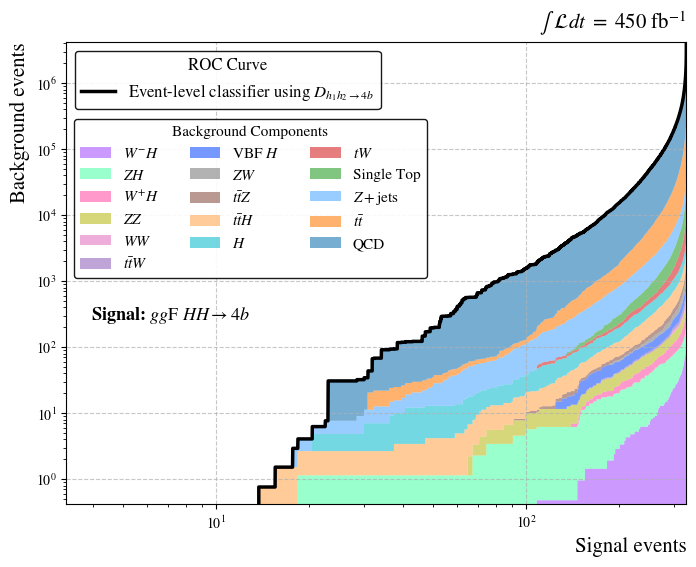

ROC curve with background composition completed.


In [37]:
lumi_scale = 4.5 # 450 fb^-1

# Weight dictionary - pre-calculated
weight_dict = { # expected_total_nevents / produced_nevents
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / (17600 * 50e5), # calculate from inclusive pythia events
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), # calculate from pre-MLM-filtered MG nevents

    # the following are calculated from inclusive nevents
    "TTbar": lumi_scale * 83175900 / 40305472, 
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

clear = False
alpha = 1
alpha_name = str(alpha).replace(".","p")

# Define background processes to track
background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
# background_processes = ['SingleTop']
discriminant = 'score_hh4bvsboth'

# Define colors for each background process
process_colors = {
    'QCD': '#1f77b4',  # blue
    'TTbar': '#ff7f0e',  # orange
    'SingleTop': '#2ca02c',  # green
    'TW': '#d62728',  # red
    'TTbarW': '#9467bd',  # purple
    'TTbarZ': '#8c564b',  # brown
    'WW': '#e377c2',  # pink
    'ZW': '#7f7f7f',  # gray
    'ZZ': '#bcbd22',  # olive
    'SingleHiggs': '#17becf',  # cyan
    'VBFH': '#1a55FF',  # blue
    'WplusH': '#FF55AA',  # pink
    'WminusH': '#AA55FF',  # purple
    'ZH': '#55FFAA',  # mint
    'ttH': '#FFAA55',  # orange
    'ZJetsToQQ': '#55AAFF'  # light blue
}

process_labels = {
    'QCD': 'QCD',
    'TTbar': r'$t\bar{t}$',  
    'SingleTop': 'Single Top',  
    'TW': '$tW$',  
    'TTbarW': r'$t\bar{t}W$',  
    'TTbarZ': r'$t\bar{t}Z$',  
    'WW': '$WW$',  
    'ZW': '$ZW$',  
    'ZZ': '$ZZ$',  
    'SingleHiggs': '$H$',  
    'VBFH': 'VBF $H$',  
    'WplusH': '$W^{+}H$',  
    'WminusH': '$W^{-}H$',  
    'ZH': '$ZH$',  
    'ttH': r'$t\bar{t}H$',  
    'ZJetsToQQ': r'$Z+\mathrm{jets}$'  
}

# Model configurations
models = [
    {
        "name": "ensemble",
        "label": "Event-level classifier",
        "color": "black",
        "marker": "*"
    },
]


def find_threshold_for_signal_events(signal_events_array, thresholds_array, target_signal_events):

    if signal_events_array[0] > signal_events_array[-1]:
        pass
    else:
        signal_events_array = signal_events_array[::-1]
        thresholds_array = thresholds_array[::-1]
    
    idx = np.argmin(np.abs(signal_events_array - target_signal_events))
    
    return thresholds_array[idx], signal_events_array[idx]


pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

# Create directory for ROC data
roc_data_dir = "roc_data_fullbg"
os.makedirs(roc_data_dir, exist_ok=True)

# Create a directory for process composition data
process_comp_dir = "process_composition"
os.makedirs(process_comp_dir, exist_ok=True)

# Function to get background process composition using histogram approach with optimized bins
def get_background_composition_hist(model_name, thresholds):
    if model_name == "ensemble":
        model_safe_name = "ensemble"
    else:
        model_safe_name = model_name.replace("../../predict/","").replace("/", "_").replace(".", "_")
    
    comp_file = f"{process_comp_dir}/alpha{alpha_name}_{model_safe_name}_bg_composition.npz"
    if clear==True:
        os.popen(f"rm -f {process_comp_dir}/alpha{alpha_name}_{model_safe_name}_bg_composition.npz").read()
    try:
        # Try to load precomputed background composition
        # os.popen(f"rm -f {process_comp_dir}/alpha{alpha_name}_{model_safe_name}_bg_composition.npz").read()
        with np.load(comp_file) as data:
            return {proc: data[proc] for proc in background_processes if proc in data.files}
    except:
        print(f"Computing background composition for {model_name}...")
        
        # Fix extreme values in thresholds
        fixed_thresholds = thresholds.copy()
        fixed_thresholds[np.isinf(fixed_thresholds)] = 1.0
        fixed_thresholds[fixed_thresholds > 1.0] = 1.0
        fixed_thresholds[fixed_thresholds < 0.0] = 0.0
        
        # Sort thresholds for bin creation (descending order, so largest values first)
        sorted_thresholds = np.sort(fixed_thresholds)[::-1]
        
        # Keep the first 1000 values (closest to 1.0)
        high_precision_thresholds = sorted_thresholds[:1000]
        
        # For the remaining thresholds, sample logarithmically
        remaining_thresholds = sorted_thresholds[1000:]
        if len(remaining_thresholds) > 0:
            # Calculate how many samples we want from the remaining thresholds
            # More samples for larger datasets
            num_samples = min(2000, max(500, len(remaining_thresholds) // 100))
            
            # Create logarithmically spaced indices
            if len(remaining_thresholds) > 1:
                # Use log spacing for indices
                log_indices = np.logspace(
                    np.log10(1),  # Start from index 1
                    np.log10(len(remaining_thresholds)), 
                    num_samples
                ).astype(int) - 1  # Convert to 0-based indices
                
                # Remove duplicates and sort
                log_indices = np.unique(log_indices)
                
                # Sample thresholds at these indices
                sampled_thresholds = remaining_thresholds[log_indices]
            else:
                sampled_thresholds = remaining_thresholds
        
            # Combine high precision and sampled thresholds
            bins = np.concatenate([high_precision_thresholds, sampled_thresholds])
        else:
            bins = high_precision_thresholds

        # Ensure bins include 0 and are sorted
        if bins[-1] > 0:
            bins = np.append(bins, 0.0)
        bins = np.sort(bins)
        
        print(f"Using {len(bins)} bins for histogram")
        print(bins, len(bins))
        
        # Dictionary to store histograms for each background process
        bg_histograms = {proc: np.zeros(len(bins)-1) for proc in background_processes}
        
        if model_name == "ensemble":
            # Ensemble处理逻辑
            ensemble_models = [
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1", 
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
            ]
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                print(proc_name)
                if proc_name == 'ggHH' or proc_name == 'qqHH':
                    continue  # Skip signal processes
                
                if proc_name not in background_processes:
                    continue  # Skip processes not in our list
                    
                # Get weight
                weight = weight_dict.get(proc_name, 1.0)
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for ifile in matching_files:
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    print(name)
                    
                    model_data = {}
                    model_fit_cuts = {}
                    
                    for model_idx, ensemble_model_name in enumerate(ensemble_models):
                        # Build file paths
                        pred_file = f"{pred_folder}/{ensemble_model_name}/pred_{name}.root"
                        flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                        dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{ensemble_model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                        
                        try:
                            # Load prediction data
                            pred_data_tmp = uproot.lazy(pred_file)
                            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                            
                            # Load flag data
                            with np.load(flag_file) as data:
                                btag_flags = {
                                    'pass_trigger': data['pass_trigger'],
                                    'pass_btag': data['pass_btag'],
                                }
                            
                            # Calculate HH4b vs QCD score
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
                            pred_data['score_hh4bvsttbar'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_137'])
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + alpha * pred_data['score_137'])

                            fit_results = np.load(dcbfit_file)

                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']

                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean

                            seed_value = int(hashlib.md5(name.encode()).hexdigest(), 16) % (2**32)
                            random.seed(seed_value)
                            np.random.seed(seed_value)

                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new

                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                # peak_cut
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            
                            model_data[model_idx] = {
                                'score_hh4bvsboth': ak.to_numpy(pred_data['score_hh4bvsboth']),
                                'fit_cut': fit_cut
                            }
                            model_fit_cuts[model_idx] = fit_cut
                            
                        except Exception as e:
                            print(f"Error processing ensemble model {model_idx} file {pred_file}: {e}")
                            model_data[model_idx] = None
                            model_fit_cuts[model_idx] = None
                    
                    if any(data is None for data in model_data.values()):
                        print(f"Skipping {name} due to missing model data")
                        continue
                    
                    lengths = [len(model_data[i]['score_hh4bvsboth']) for i in range(3)]
                    if not all(length == lengths[0] for length in lengths):
                        print(f"Warning: Model data lengths don't match for {name}: {lengths}")
                        continue
                    
                    combined_fit_cut = (np.sum([model_fit_cuts[0], model_fit_cuts[1], model_fit_cuts[2]], axis=0) >= 2 )
                    
                    if ak.sum(combined_fit_cut) == 0:
                        print(f"No events pass combined fit_cut for {name}")
                        continue
                    
                    scores_model0 = model_data[0]['score_hh4bvsboth'][combined_fit_cut]
                    scores_model1 = model_data[1]['score_hh4bvsboth'][combined_fit_cut]
                    scores_model2 = model_data[2]['score_hh4bvsboth'][combined_fit_cut]
                    
                    ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
                    
                    # Get scores and create weighted histogram
                    weights = np.ones(len(ensemble_scores)) * weight
                    
                    # Fill histogram for this process
                    hist, _ = np.histogram(ensemble_scores, bins=bins, weights=weights)
                    bg_histograms[proc_name] += hist
        else:
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                print(proc_name)
                if proc_name == 'ggHH' or proc_name == 'qqHH':
                    continue  # Skip signal processes
                
                if proc_name not in background_processes:
                    continue  # Skip processes not in our list
                    
                # Get weight
                weight = weight_dict.get(proc_name, 1.0)
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for ifile in matching_files:
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    print(name)
                    # Build file paths
                    pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
                    flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                    dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethod/{model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                    
                    try:
                        # Load prediction data
                        pred_data_tmp = uproot.lazy(pred_file)
                        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                        
                        # Load flag data
                        with np.load(flag_file) as data:
                            btag_flags = {
                                'pass_trigger': data['pass_trigger'],
                                'pass_btag': data['pass_btag'],
                            }
                        
                        # Calculate HH4b vs QCD score
                        if not "hh4b_resolved_newsp4_allparts_nosel" in model_name:
                            pred_data['score_hh4bvsqcd'] = pred_data['score_is_hh4b'] / (pred_data['score_is_hh4b'] + pred_data['score_is_qcd'])
                        else:
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
                            pred_data['score_hh4bvsttbar'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_137'])
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + alpha * pred_data['score_137'])

                            fit_results = np.load(dcbfit_file)

                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']

                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean

                            seed_value = int(hashlib.md5(name.encode()).hexdigest(), 16) % (2**32)
                            random.seed(seed_value)
                            np.random.seed(seed_value)

                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new

                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                # peak_cut
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            assert len(fit_cut)==len(pred_data)
                            
                            pred_data = pred_data[fit_cut]

                        
                        # Get scores and create weighted histogram
                        scores = ak.to_numpy(pred_data[discriminant])
                        weights = np.ones(len(scores)) * weight
                        
                        # Fill histogram for this process
                        hist, _ = np.histogram(scores, bins=bins, weights=weights)
                        bg_histograms[proc_name] += hist
                            
                    except Exception as e:
                        print(f"Error processing file {pred_file}: {e}")
        
        # Calculate cumulative sums (from right to left) to get events passing each threshold
        bg_composition = {}
        for proc in bg_histograms:
            # Reverse cumulative sum (events with score >= threshold)
            cumsum = np.cumsum(bg_histograms[proc][::-1])[::-1]
            print(cumsum, len(cumsum))
            bg_composition[proc] = cumsum
        
        # Interpolate to get values at exact thresholds
        bg_composition_at_thresholds = {proc: np.zeros_like(thresholds) for proc in bg_histograms}
        
        # Bin edges for interpolation
        bin_edges = bins
        
        # Create a mapping function from threshold to cumulative sum
        for proc in bg_histograms:
            # For each process, create an interpolation function
            # that maps from threshold to cumulative events
            print(proc)
            for i, threshold in enumerate(thresholds):
                # if i >= 10000: 
                #     if i%100 != 0 and i!=len(thresholds)-1: continue
                if threshold <= 0:
                    # All events pass if threshold <= 0
                    bg_composition_at_thresholds[proc][i] = bg_composition[proc][0]
                elif threshold >= 1:
                    # No events pass if threshold >= 1
                    bg_composition_at_thresholds[proc][i] = 0
                else:
                    # Find the bin that contains this threshold
                    bin_idx = np.searchsorted(bin_edges, threshold) - 1
                    if bin_idx < 0:
                        bin_idx = 0
                    elif bin_idx >= len(bg_composition[proc]):
                        bin_idx = len(bg_composition[proc]) - 1
                    
                    # Use the value from that bin
                    # For more precision, we could interpolate between bins
                    bg_composition_at_thresholds[proc][i] = bg_composition[proc][bin_idx]
        
        # Save background composition data
        np.savez(comp_file, **bg_composition_at_thresholds)
        # print(bg_composition_at_thresholds)
        return bg_composition_at_thresholds



# Create a single figure for both ROC curve and background composition
fig, ax = plt.subplots(figsize=(8, 6))

# Process each model
for model_config in models:
    model_name = model_config["name"]
    if model_name == "ensemble":
        model_safe_name = "ensemble"
    else:
        model_safe_name = model_name.replace("../../predict/","").replace("/", "_").replace(".", "_")

    print(f"\nProcessing model: {model_name}")

    if clear==True:
        os.popen(f"rm -f {roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz").read()

    try:
        # os.popen(f"rm -f {roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz").read()
        with np.load(f"{roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz") as data:
            fpr = data['fpr']
            tpr = data['tpr']
            auc = data['auc']
            thresholds = data['thresholds']
            total_signal = data['signal']
            total_background = data['background']
            
    except:
        # Initialize signal and background data lists
        signal_data = []
        background_data = []
        
        if model_name == "ensemble":
            ensemble_models = [
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1", 
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
            ]
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if proc_name == 'qqHH':
                    continue

                if proc_name not in weight_dict.keys():
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for ifile in matching_files:
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    print(name)
                    
                    model_data = {}
                    model_fit_cuts = {}
                    
                    for model_idx, ensemble_model_name in enumerate(ensemble_models):
                        # Build file paths
                        pred_file = f"{pred_folder}/{ensemble_model_name}/pred_{name}.root"
                        flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                        dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{ensemble_model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                        
                        try:
                            # Load prediction data
                            pred_data_tmp = uproot.lazy(pred_file)
                            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                            
                            # Load flag data
                            with np.load(flag_file) as data:
                                btag_flags = {
                                    'pass_trigger': data['pass_trigger'],
                                    'pass_btag': data['pass_btag'],
                                }
                            
                            # Calculate HH4b vs QCD score
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
                            pred_data['score_hh4bvsttbar'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_137'])
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + alpha * pred_data['score_137'])

                            fit_results = np.load(dcbfit_file)

                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']

                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean

                            seed_value = int(hashlib.md5(name.encode()).hexdigest(), 16) % (2**32)
                            random.seed(seed_value)
                            np.random.seed(seed_value)

                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new

                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                # peak_cut
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            
                            model_data[model_idx] = {
                                'score_hh4bvsboth': ak.to_numpy(pred_data['score_hh4bvsboth']),
                                'fit_cut': fit_cut
                            }
                            model_fit_cuts[model_idx] = fit_cut
                            
                        except Exception as e:
                            print(f"Error processing ensemble model {model_idx} file {pred_file}: {e}")
                            model_data[model_idx] = None
                            model_fit_cuts[model_idx] = None
                    
                    if any(data is None for data in model_data.values()):
                        print(f"Skipping {name} due to missing model data")
                        continue
                    
                    lengths = [len(model_data[i]['score_hh4bvsboth']) for i in range(3)]
                    if not all(length == lengths[0] for length in lengths):
                        print(f"Warning: Model data lengths don't match for {name}: {lengths}")
                        continue
                    
                    combined_fit_cut = (np.sum([model_fit_cuts[0], model_fit_cuts[1], model_fit_cuts[2]], axis=0) >= 2 )
                    
                    if ak.sum(combined_fit_cut) == 0:
                        print(f"No events pass combined fit_cut for {name}")
                        continue
                    
                    scores_model0 = model_data[0]['score_hh4bvsboth'][combined_fit_cut]
                    scores_model1 = model_data[1]['score_hh4bvsboth'][combined_fit_cut]
                    scores_model2 = model_data[2]['score_hh4bvsboth'][combined_fit_cut]
                    
                    ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
                    
                    # Create weighted data
                    weighted_data = {
                        'score': ensemble_scores,
                        'weight': np.ones(len(ensemble_scores)) * weight 
                    }
                    
                    # Add data to appropriate list
                    if is_signal:
                        signal_data.append(weighted_data)
                    else:
                        background_data.append(weighted_data)
        else:
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if proc_name == 'qqHH':
                    continue

                if proc_name not in weight_dict.keys():
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for ifile in matching_files:
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    # Build file paths
                    pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
                    flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                    dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethod/{model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"

                    print(name)
                    
                    try:
                        # Load prediction data
                        pred_data_tmp = uproot.lazy(pred_file)
                        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                        
                        # Load flag data
                        with np.load(flag_file) as data:
                            btag_flags = {
                                'pass_trigger': data['pass_trigger'],
                                'pass_btag': data['pass_btag'],
                            }
                        
                        # Calculate HH4b vs QCD score
                        if not "hh4b_resolved_newsp4_allparts_nosel" in model_name:
                            pred_data['score_hh4bvsqcd'] = pred_data['score_is_hh4b'] / (pred_data['score_is_hh4b'] + pred_data['score_is_qcd'])
                        else:
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
                            pred_data['score_hh4bvsttbar'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_137'])
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + alpha * pred_data['score_137'])

                            fit_results = np.load(dcbfit_file)

                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']

                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean

                            seed_value = int(hashlib.md5(name.encode()).hexdigest(), 16) % (2**32)
                            random.seed(seed_value)
                            np.random.seed(seed_value)

                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new

                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                # peak_cut
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            assert len(fit_cut)==len(pred_data)
                            
                            pred_data = pred_data[fit_cut]
                        
                        # Create weighted data
                        weighted_data = {
                            'score': ak.to_numpy(pred_data[discriminant]),
                            'weight': np.ones(len(pred_data)) * weight 
                        }
                        
                        # Add data to appropriate list
                        if is_signal:
                            signal_data.append(weighted_data)
                        else:
                            background_data.append(weighted_data)
                            
                    except Exception as e:
                        print(f"Error processing file {pred_file}: {e}")
        
        # Merge all signal and background data
        if not signal_data or not background_data:
            print(f"Warning: Model {model_name} doesn't have enough data")
            continue
            
        # Extract scores and weights
        y_score_s = np.concatenate([d['score'] for d in signal_data])
        y_weight_s = np.concatenate([d['weight'] for d in signal_data])
        
        y_score_b = np.concatenate([d['score'] for d in background_data])
        y_weight_b = np.concatenate([d['weight'] for d in background_data])
        
        # Combine scores and labels
        y_score = np.concatenate([y_score_s, y_score_b])
        y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
        y_weight = np.concatenate([y_weight_s, y_weight_b])
        
        # Remove NaN values
        valid_mask = ~np.isnan(y_score)
        print("Num of nan_score:", np.sum(np.isnan(y_score)))
        y_true = y_true[valid_mask]
        y_score = y_score[valid_mask]
        y_weight = y_weight[valid_mask]
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
        auc = m.auc(fpr, tpr)

        # Calculate weighted event totals
        total_signal = np.sum(y_weight_s)
        total_background = np.sum(y_weight_b)
    
        # Save ROC data for this model
        if model_name == "ensemble":
            model_safe_name = "ensemble"
        else:
            model_safe_name = model_name.replace("../../predict/","").replace("/", "_").replace(".", "_")
            
        np.savez(f"{roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz", 
                 fpr=fpr, 
                 tpr=tpr, 
                 thresholds=thresholds,
                 auc=auc,
                 signal=total_signal,
                 background=total_background)

    
    print(f"{model_config['label']} - Weighted signal events total: {total_signal:.2f}")
    print(f"{model_config['label']} - Weighted background events total: {total_background:.2f}")
    
    # Store reference values
    reference_total_signal = total_signal
    reference_total_background = total_background
    
    # Convert efficiencies to event counts
    signal_events = tpr * total_signal
    background_events = fpr * total_background
    
    # Get background composition for different thresholds using histogram approach
    bg_composition = get_background_composition_hist(model_name, thresholds)
    # print(bg_composition)
    
    # Reverse the order to match the ROC curve (from high threshold to low)
    signal_events_rev = signal_events[::-1]
    
    # Filter processes with non-zero contribution
    active_processes = []
    for proc in background_processes:
        if proc in bg_composition and np.any(bg_composition[proc] > 0):
            active_processes.append(proc)
    
    # Get the contribution of each process at threshold=0 (first element after reversal)
    proc_contributions = {}
    for proc in active_processes:
        # The first element in the reversed array corresponds to threshold=0
        proc_contributions[proc] = bg_composition[proc][::-1][0]
    
    # Sort processes by their contribution at threshold=0 (largest to smallest)
    sorted_processes = sorted(active_processes, key=lambda p: proc_contributions[p])

    # x_vals = signal_events
    
    # Create stacked data in the sorted order
    stack_data = []
    stack_colors = []
    stack_labels = []
    
    for proc in sorted_processes:
        stack_data.append(bg_composition[proc][::-1])  # Reverse to match ROC
        # stack_data.append(bg_composition[proc]) 
        stack_colors.append(process_colors[proc])
        stack_labels.append(process_labels[proc])

        # print(proc, bg_composition[proc][::-1], bg_composition[proc], len(bg_composition[proc][::-1]))
        # print(bg_composition[proc][bg_composition[proc]!=0])
    
    # Convert to numpy array for stacking
    stack_data = np.vstack(stack_data)

    # print(stack_data)
    
    # First plot the stacked area (background composition)
    ax.stackplot(signal_events_rev, stack_data, colors=stack_colors, labels=stack_labels, alpha=0.6)
    
    # Then plot the ROC curve on top to ensure it's visible
    if alpha==1:
        ax.plot(signal_events, background_events, 
                color=model_config['color'], linewidth=2.5,
                label=f"{model_config['label']}" + r" using $D_{h_1 h_2\to 4b}$")
    else:
        ax.plot(signal_events, background_events, 
                color=model_config['color'], linewidth=2.5,
                label=f"{model_config['label']}" + r" using $D_{h_1 h_2\to 4b}^{\mathrm{QCD}}$")

    target_signal = 20.463
    threshold_value, actual_signal = find_threshold_for_signal_events(signal_events, thresholds, target_signal)

    print(f"\n{model_config['label']} - results:")
    print(f"Target N_signal: {target_signal:.3f}")
    print(f"Most close actual N_signal: {actual_signal:.3f}")
    print(f"Threshold: {threshold_value:.6f}")
    print(f"N_bg under this threshold: {background_events[np.where(signal_events == actual_signal)[0][0]]:.3f}")

# Set plot properties
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

# Scale axes using reference values
x_min = 1e-2 * reference_total_signal
x_max = reference_total_signal 
y_min = 1e-7 * reference_total_background
y_max = reference_total_background 

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)

# Add text description
ax.text(0.04, 0.4, r'Signal: $gg\mathrm{F}$ $HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)

ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, 
        transform=ax.transAxes, ha='right', va='bottom')


# Create two separate legends
# 1. For the ROC curve
handles_roc, labels_roc = [], []
for line in ax.get_lines():
    handles_roc.append(line)
    labels_roc.append(line.get_label())

# 2. For the background composition
handles_bg, labels_bg = [], []
for collection in ax.collections:
    if hasattr(collection, 'get_label') and collection.get_label() != '_nolegend_':
        handles_bg.append(collection)
        labels_bg.append(collection.get_label())

# Add ROC legend at top left
legend1 = ax.legend(handles_roc, labels_roc, loc='upper left', 
                   framealpha=0.9, edgecolor='black', title='ROC Curve', fontsize=12, title_fontsize=12)

# Get the position of the first legend
bbox1 = legend1.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
# Calculate the position for the second legend just below the first one
# The y-coordinate is adjusted based on the height of the first legend
legend2_y = bbox1.y0 - 0.02  # Small gap between legends

# Add background composition legend at a fixed position below where the ROC legend is expected to be
legend2 = plt.legend(handles_bg, labels_bg, 
                    loc='upper left',
                    bbox_to_anchor=(0, 0.85),  # Adjust this y-coordinate as needed
                    framealpha=0.9, edgecolor='black', 
                    title='Background Components',
                    fontsize=11, ncol=3, title_fontsize=11)

# Add the first legend back after creating the second one
ax.add_artist(legend1)


# Save plot
plt.savefig(f'PLOTS/ensemble_alpha{alpha_name}_roc_with_background_composition.png', dpi=300, bbox_inches='tight')
plt.savefig(f'PLOTS/ensemble_alpha{alpha_name}_roc_with_background_composition.pdf', dpi=120, bbox_inches='tight')
plt.show()

print("ROC curve with background composition completed.")


Successfully loaded ROC data:
- Number of data points: 241603
- AUC: 0.9836
- Total signal events: 328.80
- Total background events: 4144261.65

--- Testing savgol heavy ---
Data selection (heavy): 240836 -> 400 points


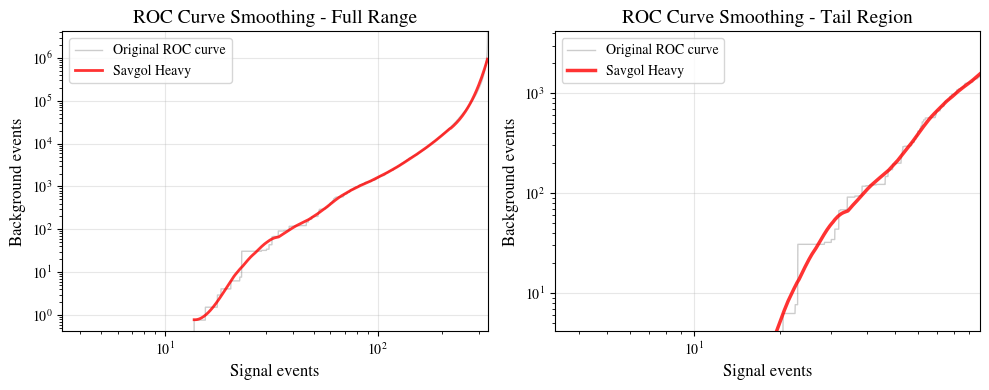

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, interp1d
from scipy.signal import savgol_filter
import os

# Set parameters
alpha = 1
alpha_name = str(alpha).replace(".", "p")
roc_data_dir = "roc_data_fullbg"

def load_roc_data():
    """Load saved ROC data"""
    model_safe_name = "ensemble"
    roc_file = f"{roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz"
    
    try:
        with np.load(roc_file) as data:
            fpr = data['fpr']
            tpr = data['tpr']
            thresholds = data['thresholds']
            auc = data['auc']
            total_signal = data['signal']
            total_background = data['background']
            
        print(f"Successfully loaded ROC data:")
        print(f"- Number of data points: {len(fpr)}")
        print(f"- AUC: {auc:.4f}")
        print(f"- Total signal events: {total_signal:.2f}")
        print(f"- Total background events: {total_background:.2f}")
        
        return fpr, tpr, thresholds, auc, total_signal, total_background
    
    except FileNotFoundError:
        print(f"Error: File not found {roc_file}")
        return None

def remove_duplicates_average(x, y, tolerance=1e-12):
    """Remove duplicate x values by averaging corresponding y values"""
    if len(x) == 0:
        return x, y
    
    # Sort by x values
    sort_indices = np.argsort(x)
    x_sorted = x[sort_indices]
    y_sorted = y[sort_indices]
    
    x_unique = []
    y_unique = []
    
    i = 0
    while i < len(x_sorted):
        current_x = x_sorted[i]
        y_values = [y_sorted[i]]
        
        j = i + 1
        while j < len(x_sorted) and abs(x_sorted[j] - current_x) <= tolerance:
            y_values.append(y_sorted[j])
            j += 1
        
        x_unique.append(current_x)
        y_unique.append(np.mean(y_values))
        i = j
    
    return np.array(x_unique), np.array(y_unique)

def smart_data_selection(x, y, target_points=1000):
    """
    Smart data selection that preserves curve shape while reducing points
    """
    # Remove duplicates first
    x_clean, y_clean = remove_duplicates_average(x, y)
    
    if len(x_clean) <= target_points:
        return x_clean, y_clean
    
    # Sort by x values
    sort_indices = np.argsort(x_clean)
    x_sorted = x_clean[sort_indices]
    y_sorted = y_clean[sort_indices]
    
    # Use logarithmic spacing to better sample the curve
    log_x = np.log10(x_sorted)
    
    # Create target log-spaced x values
    log_x_target = np.linspace(log_x.min(), log_x.max(), target_points)
    
    # Find closest indices for each target point
    selected_indices = []
    for log_x_val in log_x_target:
        closest_idx = np.argmin(np.abs(log_x - log_x_val))
        selected_indices.append(closest_idx)
    
    # Remove duplicates and sort
    selected_indices = sorted(list(set(selected_indices)))
    
    # Always include endpoints
    if 0 not in selected_indices:
        selected_indices = [0] + selected_indices
    if len(x_sorted)-1 not in selected_indices:
        selected_indices = selected_indices + [len(x_sorted)-1]
    
    return x_sorted[selected_indices], y_sorted[selected_indices]

def smooth_roc_curve_final(signal_events, background_events, method='pchip', smoothing_level='medium'):
    """
    Final ROC curve smoothing with only good methods
    """
    # Remove invalid values
    valid_mask = (signal_events > 0) & (background_events > 0) & np.isfinite(signal_events) & np.isfinite(background_events)
    x_valid = signal_events[valid_mask]
    y_valid = background_events[valid_mask]
    
    # Smart data selection - more aggressive reduction for smoother curves
    if smoothing_level == 'light':
        target_points = 1500
    elif smoothing_level == 'medium':
        target_points = 800
    else:  # heavy
        target_points = 400
    
    x_selected, y_selected = smart_data_selection(x_valid, y_valid, target_points)
    
    print(f"Data selection ({smoothing_level}): {len(x_valid)} -> {len(x_selected)} points")
    
    # Convert to log space
    log_x = np.log10(x_selected)
    log_y = np.log10(y_selected)
    
    # Remove duplicates in log space
    log_x_clean, log_y_clean = remove_duplicates_average(log_x, log_y, tolerance=1e-12)
    
    if method == 'pchip':
        # PCHIP with different smoothing levels
        if smoothing_level == 'light':
            # Use original PCHIP
            interpolator = PchipInterpolator(log_x_clean, log_y_clean)
        else:
            # Pre-smooth the data before PCHIP for more smoothing
            if len(log_x_clean) > 10:
                # Apply light Savgol filter first
                window_length = min(11 if smoothing_level == 'medium' else 21, len(log_x_clean)//3)
                if window_length % 2 == 0:
                    window_length += 1
                window_length = max(window_length, 5)
                
                # Interpolate to uniform grid for Savgol
                log_x_uniform = np.linspace(log_x_clean.min(), log_x_clean.max(), len(log_x_clean))
                f_temp = interp1d(log_x_clean, log_y_clean, kind='linear')
                log_y_uniform = f_temp(log_x_uniform)
                
                # Apply Savgol filter
                log_y_presmooth = savgol_filter(log_y_uniform, window_length, 3)
                
                # Use pre-smoothed data for PCHIP
                interpolator = PchipInterpolator(log_x_uniform, log_y_presmooth)
            else:
                interpolator = PchipInterpolator(log_x_clean, log_y_clean)
        
        log_x_smooth = np.linspace(log_x_clean.min(), log_x_clean.max(), 2000)
        log_y_smooth = interpolator(log_x_smooth)
        
    elif method == 'savgol':
        # Savitzky-Golay filter with different smoothing levels
        
        # Interpolate to uniform grid first
        n_uniform = min(len(log_x_clean)*3, 3000) if smoothing_level == 'light' else \
                   min(len(log_x_clean)*2, 2000) if smoothing_level == 'medium' else \
                   min(len(log_x_clean), 1000)
        
        log_x_uniform = np.linspace(log_x_clean.min(), log_x_clean.max(), n_uniform)
        
        # Interpolate to uniform grid
        f_interp = interp1d(log_x_clean, log_y_clean, kind='linear', fill_value='extrapolate')
        log_y_uniform = f_interp(log_x_uniform)
        
        # Apply Savitzky-Golay filter with different window sizes
        if smoothing_level == 'light':
            window_length = min(31, len(log_y_uniform)//8)
        elif smoothing_level == 'medium':
            window_length = min(51, len(log_y_uniform)//6)
        else:  # heavy
            window_length = min(101, len(log_y_uniform)//4)
        
        if window_length % 2 == 0:
            window_length += 1
        window_length = max(window_length, 5)
        
        log_y_smooth = savgol_filter(log_y_uniform, window_length, 3)
        log_x_smooth = log_x_uniform
    
    # Convert back to linear space
    x_smooth = 10**log_x_smooth
    y_smooth = 10**log_y_smooth
    
    return x_smooth, y_smooth, x_selected, y_selected

def main():
    # Load data
    data = load_roc_data()
    if data is None:
        return
    
    fpr, tpr, thresholds, auc, total_signal, total_background = data
    
    # Convert to event counts
    signal_events = tpr * total_signal
    background_events = fpr * total_background
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Test different smoothing levels for the two good methods
    methods_configs = [
        # ('pchip', 'light', 'red', 'PCHIP Light'),
        # ('pchip', 'medium', 'darkred', 'PCHIP Medium'),
        # ('pchip', 'heavy', 'maroon', 'PCHIP Heavy'),
        # ('savgol', 'light', 'green', 'Savgol Light'),
        # ('savgol', 'medium', 'blue', 'Savgol Medium'),
        ('savgol', 'heavy', 'red', 'Savgol Heavy'),
    ]
    
    for i, (method, smoothing_level, color, label) in enumerate(methods_configs):
        try:
            print(f"\n--- Testing {method} {smoothing_level} ---")
            x_smooth, y_smooth, x_selected, y_selected = smooth_roc_curve_final(
                signal_events, background_events, method=method, smoothing_level=smoothing_level
            )
            
            # Left plot: full range comparison
            if i == 0:
                ax1.plot(signal_events, background_events, 'k-', alpha=0.2, linewidth=1, 
                        label='Original ROC curve')
            
            ax1.plot(x_smooth, y_smooth, color=color, linewidth=2, alpha=0.8, label=label)
            
            # Right plot: tail region zoom
            if i == 0:
                ax2.plot(signal_events, background_events, 'k-', alpha=0.2, linewidth=1,
                        label='Original ROC curve')
            
            ax2.plot(x_smooth, y_smooth, color=color, linewidth=2.5, alpha=0.8, label=label)
            
        except Exception as e:
            print(f"{method} {smoothing_level} failed: {e}")
            import traceback
            traceback.print_exc()
    
    # Set left plot (full range)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-2 * total_signal, total_signal)
    ax1.set_ylim(1e-7 * total_background, total_background)
    ax1.set_xlabel('Signal events', fontsize=12)
    ax1.set_ylabel('Background events', fontsize=12)
    ax1.set_title('ROC Curve Smoothing - Full Range', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Set right plot (tail region zoom)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-2 * total_signal, 3e-1 * total_signal)
    ax2.set_ylim(1e-6 * total_background, 1e-3 * total_background)
    ax2.set_xlabel('Signal events', fontsize=12)
    ax2.set_ylabel('Background events', fontsize=12)
    ax2.set_title('ROC Curve Smoothing - Tail Region', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    
    # Save plots
    os.makedirs('PLOTS', exist_ok=True)
    plt.savefig(f'PLOTS/alpha{alpha_name}_roc_smoothing_final.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'PLOTS/alpha{alpha_name}_roc_smoothing_final.pdf', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()
